<a href="https://colab.research.google.com/github/anne-urai/ddm_mediation/blob/main/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First, set Runtime -> Runtime type -> GPU for fitting

# https://hddm.readthedocs.io/en/latest/lan_tutorial.html
!pip install scikit-learn
!pip install cython
!pip install pymc

!pip install -U --no-deps git+https://github.com/anne-urai/hddm
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki


# MODULE IMPORTS ----
# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# to download data
from google.colab import files
import pprint

# HDDM
import hddm

     |████████████████████████████████| 385 kB 4.3 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1361122 sha256=e92aba1296285ac1f671ddb24f080dc3821c9f868c7e3189b1e54811eb9d96ac
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc
  Cloning https://github.com/anne-urai/hddm to /tmp/pip-req-build-dcwmvdqc
  Running command git clone -q https://github.com/anne-urai/hddm /tmp/pip-req-build-dcwmvdqc
  Running command git submodule update --init --recursive -q
  Created wheel for HDDM: filename=HDDM-0.9.3-cp37-cp37m-linux_x86_64.whl size=3874717 sha256=361d67449e81d681cd580a6aa1eb7d9ac46e05504f771c9282df6bc753df954b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7apom7a3/wheels/fa/1c/d6/4d91002b5305b3dc76ca13cd496b9bbfd0fc9350d27ab615ca
Successfully built HDDM
  Cloning https://github.com/hddm-devs/kabuki to /tmp/pip-req-build-kk1rj75f
  Running command git clone -q https:/

In [2]:
##  ============================================================= ##
## generate some artificial choice data with mediation variable
##  ============================================================= ##

# first, previous choices ('X')
n_trials = 500
n_subj = 20
df = pd.DataFrame(np.random.choice([-1,1], (n_trials*n_subj, 2)), 
                  columns=list('XS')) 

# then a normally distributed random variable, that depends on X
df['M'] = np.random.normal(size=n_trials*n_subj) + df['X']

# make sure we have subj_idx and trial_idx
subj_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    subj_idx.append(s)

trial_idx = []
for s in np.arange(n_subj) + 1:
  for n in np.arange(n_trials):
    trial_idx.append(n)

df['subj_idx'] = subj_idx
df['trial_idx'] = trial_idx

df = df[['subj_idx', 'trial_idx', 'S', 'X', 'M']]
df.sample(n=10)


,subj_idx,trial_idx,S,X,M
1032,3,32,-1,1,1.126498
8045,17,45,-1,1,0.578189
1500,4,0,1,1,-0.914355
8532,18,32,1,1,1.080345
784,2,284,-1,1,1.744069
1824,4,324,1,1,1.481644
9499,19,499,-1,1,1.362418
299,1,299,1,-1,0.073753
1117,3,117,1,-1,-1.015083
406,1,406,1,1,2.526061


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmode

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: M          
No. Observations: 10000   Method:             REML       
No. Groups:       20      Scale:              1.0172     
Min. group size:  500     Likelihood:         -14338.9741
Max. group size:  500     Converged:          No         
Mean group size:  500.0                                  
----------------------------------------------------------
            Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept   0.024     0.212   0.115  0.909  -0.391   0.439
X           0.997     0.010  98.783  0.000   0.977   1.017
Group Var   0.894                                         



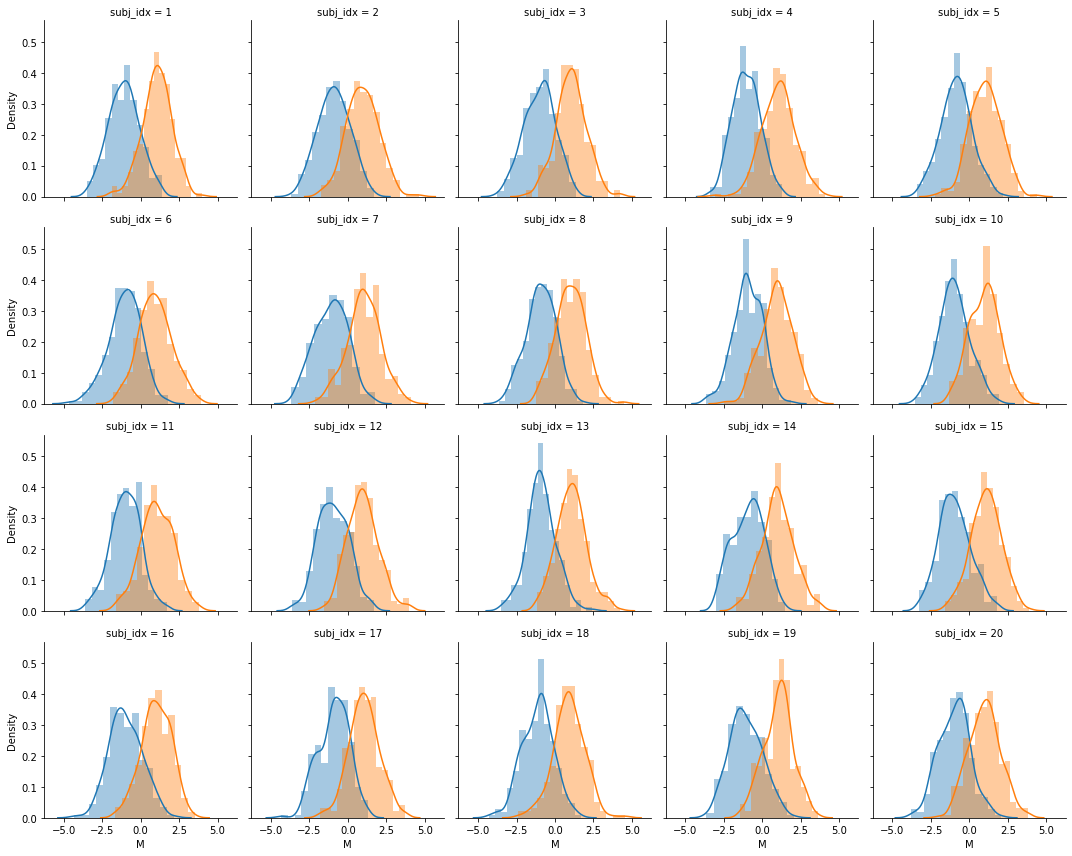

In [5]:
# DOES M DEPEND ON X (a-path)?
import statsmodels.formula.api as smf

md = smf.mixedlm("M ~ X", df, groups=df["subj_idx"])
mdf = md.fit()
print(mdf.summary())

# see the separation
g = sns.FacetGrid(data=df, col='subj_idx', col_wrap=5, hue='X')
g.map(sns.distplot, 'M')

In [3]:
##  ============================================================= ##
# plug into the HDDMnn simulator to simulate choices and RTs
##  ============================================================= ##

# help(hddm.simulators.hddm_dataset_generators.simulator_h_c)
# see https://hddm.readthedocs.io/en/latest/lan_tutorial.html#section-5-regressors 
# forum request for bug: https://groups.google.com/g/hddm-users/c/bdKDkwuQ3tk

data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(data = df, 
                                                                                  model = 'ddm',
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = ['v ~ 1 + S + X', 'z ~ 1 + X'], 
                                                                                  regression_covariates = ['S', 'X'],
                                                                                  group_only = None,
                                                                                  group_only_regressors = False,
                                                                                  fixed_at_default = None)


new round of data simulation because parameter bounds where violated
new round of data simulation because parameter bounds where violated


In [4]:
# from https://github.com/anne-urai/MEG/blob/master/hddm_funcs_plot.py#L66
# https://github.com/anne-urai/hddm/blob/master/hddm/utils.py#L925
    
param_dict = {}
for key, value in full_parameter_dict.items():
    if 'reg' not in key:
        param_dict[key] = value
param_dict
param_df = pd.DataFrame.from_dict(param_dict, orient='index').reset_index()
param_df = hddm.utils.results_long2wide(param_df, 
                                        name_col="index", 
                                        val_col=0).sort_values(by='subj_idx')
param_df

parameter,subj_idx,a,t,v_Intercept,v_S,v_X,z_Intercept,z_X
0,1,1.587060,0.439084,0.720306,0.305892,1.397897,0.663772,0.083413
1,10,1.484538,0.269404,0.541179,0.060301,1.388111,0.566090,0.224475
2,11,2.028483,0.442198,0.095505,-0.172153,1.452788,0.509734,0.040402
3,12,1.516050,0.291064,0.765614,-0.078801,1.378246,0.613085,0.140494
4,13,2.010021,0.519863,0.894405,-0.299781,1.330035,0.423536,0.056428
5,14,2.185201,0.639360,0.815358,-0.147402,1.382823,0.325458,0.119878
6,15,1.312799,0.326081,0.612920,0.082582,1.355935,0.405147,0.257936
7,16,1.909011,0.176551,1.087132,0.036462,1.401314,0.449511,0.057211
8,17,1.575289,0.553990,0.566139,-0.198291,1.383990,0.599446,0.141750
9,18,1.851020,0.726233,0.678223,-0.212371,1.356676,0.628427,0.188812


In [ ]:
# see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=p2E4EKhCWEC5
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')